Program to identify suspicious values in Prim and Dseco master file in preparation for data cleaning.

In [1]:
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

from datetime import datetime
from numpy import array, polyfit, poly1d
from pandas import DataFrame, to_datetime
from pandas.plotting import register_matplotlib_converters
from tkinter import *
from tkinter import filedialog

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()


In [2]:
def get_file():

# Select input file
    root = Tk()
    root.filename =  filedialog.askopenfilename(initialdir = "C:\QGHL\Wave_data\Masters", title = "Select Master file",\
                        filetypes = (("all files","*.*"),("Prim files","*.prim"),("Seco files","*.seco"),("Dseco files","*.dseco.corrected")))
    root.destroy()

    return(root.filename)

In [3]:
def remove_zeros(recs,Input_File):

# Locate, and remove errant zero's from data
    zero_data = recs.loc[recs.date_val.apply(lambda x: x[0])==0].index
    if len(zero_data) > 0:
        recs_zero = recs    # make a copy to locate where the zeros occur
        date_string =  [[recs.loc[zero_data[0]-1].date_val.tolist()][0][i] for i in range(0,10,2)]
        ' '.join(str(p) for p in [date_string])
        first_val = str(date_string[0])+'/'+str(date_string[1])+'/'+str(date_string[2])+' '+str(date_string[3]) \
            +':'+str(date_string[4])
        date_string =  [[recs.loc[zero_data[-1]+1].date_val.tolist()][0][i] for i in range(0,10,2)]
        ' '.join(str(p) for p in [date_string])
        last_val = str(date_string[0])+'/'+str(date_string[1])+'/'+str(date_string[2])+' '+str(date_string[3]) \
            +':'+str(date_string[4])
        print('Alert: ',len(zero_data),' Zero\'s found (and removed) between ',first_val,' and ',last_val)
    else:
        print('No zeros found in ',Input_File)

    recs = recs.loc[recs.date_val.apply(lambda x: x[0])!=0]

    return(recs)

In [4]:
def convert_dates(recs):
# Convert date/time column data into Dates and times
    Record_time = pd.DataFrame(recs.date_val.values.tolist(), \
            columns=['year','j1','month','j2','day','j3','hour','j4','minute','j5','second','j6'])

    Record_time['year'] = Record_time['year'].mask(Record_time['year'] < 1900, Record_time['year'] + 1900)

    # Insert Date column at start of DF
    recs.index = pd.to_datetime(Record_time[['year','month','day','hour','minute','second']],format='%Y:%m:%d:%H:%M:%S')

    return(recs)

In [5]:
############################################
#    MAIN PROGRAM
############################################

# Create a DT based on the structure type of the PRIM Master File
# Details copied from PV~Wave file Master_structure_types_corrected.pro
pp1 = np.dtype([
    ('P1', 'B'),('P2', 'B'),('P3', 'B'),('P4', 'B'),('P5', 'B'),('P6', 'B'),('P7', 'B'),('P8', 'B'),
    ('P9', 'B'),('P10', 'B'),('P11', 'B'),('P12', 'B')])
pp2 = np.dtype([('p1', 'f'),('p2', 'f'),('p3', 'f'),('p4', 'f')])

rectype_prim = np.dtype([
    ('Procid',pp1),
    ('Loc','i'),
#    ('Year','i'),('Month','i'),('Day', 'i'),('Hour', 'i'),('Min', 'i'), ('Sec','i'), 
    ('date_val','i2',(12)),
    ('Hsig','f4'), ('Thsig','f4'), ('Hrms', 'f'), ('Hmax', 'f'),('Tc', 'f'),('Tz', 'f'), ('H10', 'f'), 
    ('Th10', 'f'), ('Thmax', 'f'), ('Tzmax', 'f'), ('Hm0', 'f4'),('T02', 'f'),('Tp', 'f'), ('EPS', 'f'), 
    ('Npts', 'i'),
    ('Param2',pp2)])

# Create a DT based on the structure type of the DSECO Master File
# Details copied from PV~Wave file Master_structure_types_corrected.pro

pp3 = np.dtype([
    ('P1', 'B'),('P2', 'B'),('P3', 'B'),('P4', 'B'),('P5', 'B'),('P6', 'B'),('P7', 'B'),('P8', 'B'),
    ('P9', 'B'),('P10', 'B'),('P11', 'B'),('P12', 'B')])

rectype_dseco = np.dtype([
                    ('Procid',pp3),
                    ('Loc','i'),
                    ('date_val','i2',(12)),
                    ('Elapse','i2',(2)),
                    ('Dparam','f',12),
                    ('Corr_to_True','f'),
                    ('jdirn', 'i2', (64)),
                    ('jrpower', 'i2', (64)),
                    ('jspread', 'i2', (64)),                     
                   ])

############################################################################################
# Get name of input PRIM file
Input_Prim_File = get_file()
site = Input_Prim_File.split('/')[-1].split('}')[0].upper()

# Open file
f = open(Input_Prim_File)

# Read data from the Binary file into a DF based on the structure in the DT
data = np.fromfile(f, rectype_prim)
recs_prim = DataFrame.from_records(np.array(data).tolist())

# Assign column names to DF
recs_prim.columns = ['Procid','Loc','date_val','Hsig','Thsig','Hrms','Hmax','Tc','Tz','H10','Th10',
                     'Thmax','Tzmax','Hm0','T02','Tp','EPS','Npts','Param2']

############################################################################################
# Get name of input DSECO file
Input_Dseco_File = get_file()

# Open file
f = open(Input_Dseco_File)

# Read data from the Binary file into a DF based on the structure in the DT
data = np.fromfile(f, rectype_dseco)
recs_dseco = DataFrame.from_records(np.array(data).tolist())

############################################################################################
# Assign column names to DF
# Parameters in Dparam are:
#     hm0,t02,pdens,temp,vacc,xacc,yacc,orient,inclin,tp_buoy,avg_dir,peak_dir, 
recs_dseco.columns = ['Procid','Loc','date_val','Elapse','Dparam','Corr_to_True','jdirn','jrpower','jspread']


# Locate, and remove errant zero's from data
recs_prim = remove_zeros(recs_prim,Input_Prim_File)
recs_dseco = remove_zeros(recs_dseco,Input_Dseco_File)

# Convert date/time column data into Dates and times
recs_prim = convert_dates(recs_prim)
recs_dseco = convert_dates(recs_dseco)

# Remove unwanted columns from Prim DF
recs_prim = recs_prim.drop(columns=[
#    'Procid',
    'Loc',
    'date_val',
    'Param2'], axis=1)

# Create a new df from recs_dseco.Dparam indexed on recs_dseco.index, and including values from recs.Corr_to_True
df_dseco = pd.DataFrame.from_records(recs_dseco.Dparam.values.tolist(), index = recs_dseco.index, \
        columns=['hm0','t02','pdens','temp','vacc','xacc','yacc','orient','inclin','tp_buoy','avg_dir','peak_dir'])
df_dseco['corr_true'] = recs_dseco.Corr_to_True

# get Hmax
y = recs_prim.Hm0/recs_prim.Hsig
##print(y)

# The 'MS' string groups the data in buckets by start of the month
y = y.resample('MS').max()
###y = y.resample('6H').max() # <= causes Memory Error !!!

# The term bfill means that we use the value before filling in missing values
y = y.fillna(y.bfill())

No zeros found in  C:/QGHL/Wave_data/Master_files/twee----28.prim
No zeros found in  C:/QGHL/Wave_data/Master_files/twee----28.dseco.corrected


In [ ]:
for i in range(1,len(recs_prim)):
    aa = recs_prim.iloc[i].Procid
    print(recs_prim.index[i],''.join(chr(j) for j in aa))

In [6]:
# Merge .Prim and .Dseco files together by date
merged_df = recs_prim.merge(df_dseco,how='outer', left_index=True, right_index=True)

In [ ]:
# Display relationships in Prim master file
details = recs_prim.describe()
plt.rcParams['axes.facecolor'] = 'white'
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8), (ax9, ax10)) = plt.subplots(5, 2, figsize=(15,30), facecolor=(1, 1, 1))

ax1.scatter(recs_prim.Hsig,recs_prim.Hm0/recs_prim.Hsig,s=0.5,c='g')
suspect_Hm0_Hsig = recs_prim[~(recs_prim.Hm0/recs_prim.Hsig).between(1.0,1.3,inclusive=False)]
ax1.scatter(suspect_Hm0_Hsig.Hsig,suspect_Hm0_Hsig.Hm0/suspect_Hm0_Hsig.Hsig,s=2.5,c='r')
mode = details.Hm0[5]/details.Hsig[5]
ax1.plot([0,max(recs_prim.Hsig)],[mode,mode],lw=1.0,c="b",dashes=[5, 5, 5, 5])
ax1.set_xlabel("Hsig (m)")
ax1.set_ylabel("Hm0/Hsig")
ax1.plot([0,max(recs_prim.Hsig)],[1.3,1.3],lw=1.0,c="r",dashes=[5, 5, 5, 5])
ax1.plot([0,max(recs_prim.Hsig)],[1.0,1.0],lw=1.0,c="r",dashes=[5, 5, 5, 5])

ax2.scatter(recs_prim.Hsig,recs_prim.Hmax/recs_prim.Hsig,s=0.5,c='g')
suspect_Hmax_Hsig = recs_prim[~(recs_prim.Hmax/recs_prim.Hsig).between(1.4,2.5,inclusive=False)]
ax2.scatter(suspect_Hmax_Hsig.Hsig,suspect_Hmax_Hsig.Hmax/suspect_Hmax_Hsig.Hsig,s=2.5,c='r')
mode = details.Hmax[5]/details.Hsig[5]
ax2.plot([0,max(recs_prim.Hsig)],[mode,mode],lw=1.0,c="b",dashes=[5, 5, 5, 5])
ax2.set_xlabel("Hsig (m)")
ax2.set_ylabel("Hmax/Hsig")
ax2.plot([0,max(recs_prim.Hsig)],[1.4,1.4],lw=1.0,c="r",dashes=[5, 5, 5, 5])
ax2.plot([0,max(recs_prim.Hsig)],[2.5,2.5],lw=1.0,c="r",dashes=[5, 5, 5, 5])

ax3.scatter(recs_prim.Hsig,recs_prim.Hrms/recs_prim.Hsig,s=0.5,c='g')
suspect_Hrms_Hsig = recs_prim[~(recs_prim.Hrms/recs_prim.Hsig).between(0.67,0.95,inclusive=False)]
ax3.scatter(suspect_Hrms_Hsig.Hsig,suspect_Hrms_Hsig.Hrms/suspect_Hrms_Hsig.Hsig,s=3.5,c='r')
mode = details.Hrms[5]/details.Hsig[5]
ax3.plot([0,max(recs_prim.Hsig)],[mode,mode],lw=1.0,c="b",dashes=[5, 5, 5, 5])
ax3.set_xlabel("Hsig (m)")
ax3.set_ylabel("Hrms/Hsig")
ax3.plot([0,max(recs_prim.Hsig)],[0.67,0.67],lw=1.0,c="r",dashes=[5, 5, 5, 5])
ax3.plot([0,max(recs_prim.Hsig)],[0.95,0.95],lw=1.0,c="r",dashes=[5, 5, 5, 5])

ax4.scatter(recs_prim.Hsig,recs_prim.H10/recs_prim.Hsig,s=0.5,c='g')
suspect_H10_Hsig = recs_prim[~(recs_prim.H10/recs_prim.Hsig).between(1.0,1.6,inclusive=False)]
ax4.scatter(suspect_H10_Hsig.Hsig,suspect_H10_Hsig.H10/suspect_H10_Hsig.Hsig,s=3.5,c='r')
mode = details.H10[5]/details.Hsig[5]
ax4.plot([0,max(recs_prim.Hsig)],[mode,mode],lw=1.0,c="b",dashes=[5, 5, 5, 5])
ax4.set_xlabel("Hsig (m)")
ax4.set_ylabel("H10/Hsig")

ax5.scatter(recs_prim.Tz,recs_prim.T02/recs_prim.Tz,s=0.5,c='g')
suspect_Tz_T02 = recs_prim[~(recs_prim.Tz/recs_prim.T02).between(0.8,1.3,inclusive=False)]
ax5.scatter(suspect_Tz_T02.Tz,suspect_Tz_T02.T02/suspect_Tz_T02.Tz,s=3.5,c='r')
mode = details.T02[5]/details.Tz[5]
ax5.plot([0,max(recs_prim.Tz)],[mode,mode],lw=1.0,c="b",dashes=[5, 5, 5, 5])
ax5.set_xlabel("Tz (s)")
ax5.set_ylabel("T02/Tz")
ax5.plot([0,max(recs_prim.Tz)],[0.8,0.8],lw=1.0,c="r",dashes=[5, 5, 5, 5])
ax5.plot([0,max(recs_prim.Tz)],[1.3,1.3],lw=1.0,c="r",dashes=[5, 5, 5, 5])

ax6.plot(recs_prim.Tzmax,lw=0,marker='o',ms=0.5,c='g')
suspect_Tzmax = recs_prim[(recs_prim.Tzmax).gt(20)]
ax6.plot(suspect_Tzmax.Tzmax,lw=0,marker='o',ms=3.5,c='r')
ax6.set_xlabel("Date")
ax6.set_ylabel("Tzmax (s)")
ax6.plot([recs_prim.index[0],recs_prim.index[-1]],[20.0,20.0],lw=1.0,c="r",dashes=[5, 5, 5, 5])

ax7.plot(recs_prim.Tp,lw=0,marker='o',ms=0.5,c='g')
suspect_Tp = recs_prim[~(recs_prim.Tp).between(1,16,inclusive=False)]
ax7.plot(suspect_Tp.Tp,lw=0,marker='o',ms=3.5,c='r')
ax7.set_xlabel("Date")
ax7.set_ylabel("Tp (s)")
ax7.plot([recs_prim.index[0],recs_prim.index[-1]],[16.0,16.0],lw=1.0,c="r",dashes=[5, 5, 5, 5])

ax8.plot(recs_prim.Thsig,lw=0,marker='o',ms=0.5,c='g')
suspect_Thsig = recs_prim[(recs_prim.Thsig).gt(14)]
ax8.plot(suspect_Thsig.Thsig,lw=0,marker='o',ms=3.5,c='r')
ax8.set_xlabel("Date")
ax8.set_ylabel("Thsig (s)")
ax8.plot([recs_prim.index[0],recs_prim.index[-1]],[14.0,14.0],lw=1.0,c="r",dashes=[5, 5, 5, 5])

ax9.plot(recs_prim.Tc,lw=0,marker='o',ms=0.5,c='g')
suspect_Tc = recs_prim[(recs_prim.Tc).gt(14)]
ax9.plot(suspect_Tc.Tc,lw=0,marker='o',ms=3.5,c='r')
ax9.set_xlabel("Date")
ax9.set_ylabel("Tc (s)")
ax9.plot([recs_prim.index[0],recs_prim.index[-1]],[14.0,14.0],lw=1.0,c="r",dashes=[5, 5, 5, 5])

ax10.plot(recs_prim.Tz,lw=0,marker='o',ms=0.5,c='g')
suspect_Tz = recs_prim[(recs_prim.Tz).gt(14)]
ax10.plot(suspect_Tz.Tz,lw=0,marker='o',ms=3.5,c='r')
ax10.set_xlabel("Date")
ax10.set_ylabel("Tz (s)")
ax10.plot([recs_prim.index[0],recs_prim.index[-1]],[14.0,14.0],lw=1.0,c="r",dashes=[5, 5, 5, 5])

plt.show()

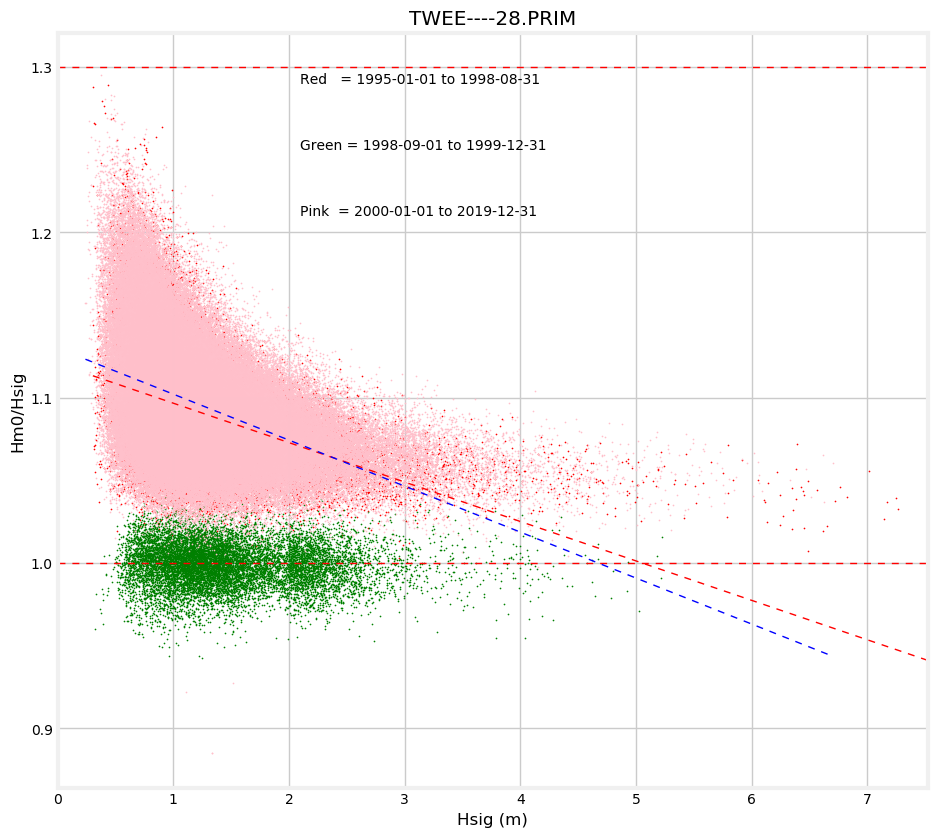

In [12]:
# Do plot of Hm0/Hsig ratio for different periods of operation
recs_prim.dropna(inplace=True)
plt.rcParams['axes.facecolor'] = 'white'
plt.figure(figsize=(10,10),dpi=100)
recs = recs_prim.loc[recs_prim.Hm0>0]
year1 = recs_prim.loc['1995-01-01':'1998-08-31']
scatter = plt.scatter(year1.Hsig,year1.Hm0/year1.Hsig,s=0.5,c='r')

year2 = recs_prim.loc['1998-09-01':'1999-12-31']
plt.scatter(year2.Hsig,year2.Hm0/year2.Hsig,s=0.5,c='g')

year3 = recs_prim.loc['2000-01-01':'2019-12-31']
plt.scatter(year3.Hsig,year3.Hm0/year3.Hsig,s=0.5,c='pink')

year4 = recs_prim.loc['2001-01-01':'2002-01-01']
#plt.scatter(year4.Hsig,year4.Hm0/year4.Hsig,s=0.5,c='yellow')

plt.xlabel("Hsig (m)")
plt.ylabel("Hm0/Hsig")

plt.text(2.1,1.29,'Red   = 1995-01-01 to 1998-08-31')
plt.text(2.1,1.25,'Green = 1998-09-01 to 1999-12-31')
plt.text(2.1,1.21,'Pink  = 2000-01-01 to 2019-12-31')
plt.xlim(0,max(recs_prim.Hsig))
##plt.ylim(0.8,1.4)
plt.title(site)
plt.plot([0,max(recs_prim.Hsig)],[1.3,1.3],lw=1.0,c="r",dashes=[5, 5, 5, 5])
plt.plot([0,max(recs_prim.Hsig)],[1.0,1.0],lw=1.0,c="r",dashes=[5, 5, 5, 5])

from numpy.polynomial import Polynomial

p = Polynomial.fit(year1.Hsig,year1.Hm0/year1.Hsig, 1)
plt.plot(*p.linspace(),lw=1.0,c="r",dashes=[5, 5, 5, 5])

p = Polynomial.fit(year2.Hsig,year2.Hm0/year2.Hsig, 1)
#plt.plot(*p.linspace(),lw=1.0,c="yellow",dashes=[5, 5, 5, 5])

p = Polynomial.fit(year3.Hsig,year3.Hm0/year3.Hsig, 1)
plt.plot(*p.linspace(),lw=1.0,c="b",dashes=[5, 5, 5, 5])

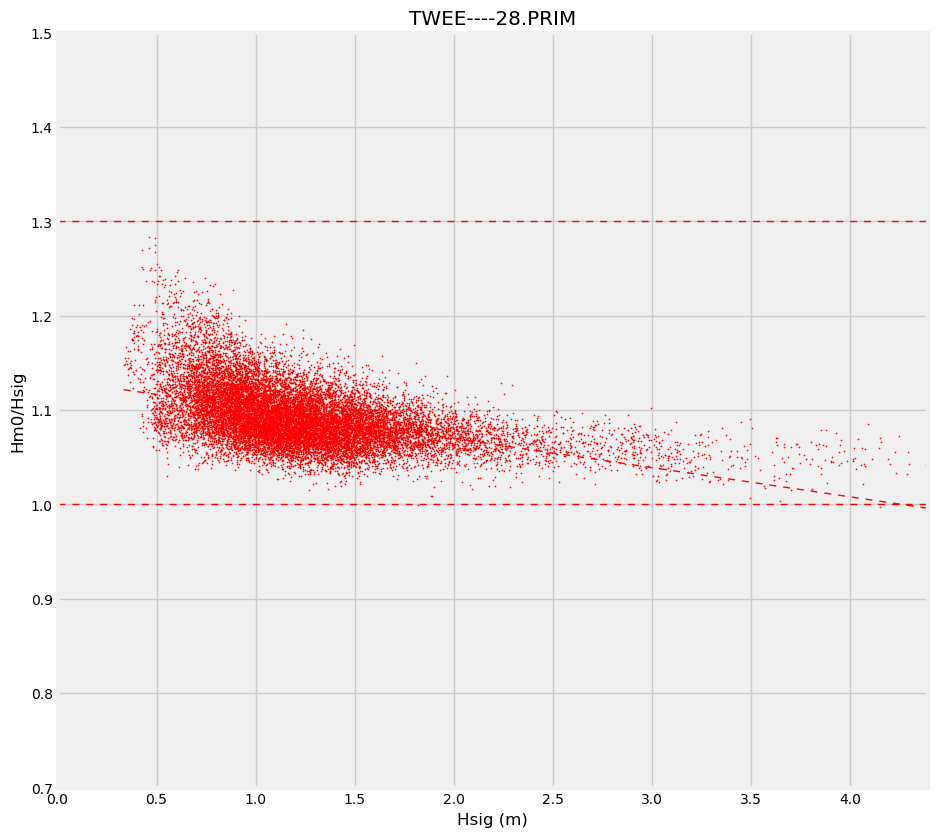

In [7]:
# Do plot of Hm0/Hsig ratio for different periods of operation
recs_prim.dropna(inplace=True)

plt.figure(figsize=(10,10),dpi=100)
recs = recs_prim.loc[recs_prim.Hm0>0]
year1 = recs_prim.loc['2001-01-01':'2002-01-01']
scatter = plt.scatter(year1.Hsig,year1.Hm0/year1.Hsig,s=0.5,c='r')

plt.xlabel("Hsig (m)")
plt.ylabel("Hm0/Hsig")

plt.xlim(0,max(year1.Hsig))
plt.ylim(ymin=0.7,ymax=1.5)

##plt.ylim(0.8,1.4)
plt.title(site)
plt.plot([0,max(recs_prim.Hsig)],[1.3,1.3],lw=1.0,c="r",dashes=[5, 5, 5, 5])
plt.plot([0,max(recs_prim.Hsig)],[1.0,1.0],lw=1.0,c="r",dashes=[5, 5, 5, 5])

from numpy.polynomial import Polynomial

p = Polynomial.fit(year1.Hsig,year1.Hm0/year1.Hsig, 1)
plt.plot(*p.linspace(),lw=1.0,c="r",dashes=[5, 5, 5, 5])



In [ ]:
year1

In [ ]:
plt.figure(figsize=(15,10),dpi=100)
plt.title(site)

# only plot records where Hsig > 0
year1 = year1.loc[year1.Hsig>0]

plt.plot(year1.index,year1.Hmax,lw=0.5,c="b")
plt.plot(year1.index,year1.Hm0,lw=0.5,c="r",dashes=[5, 5, 5, 5])
plt.plot(year1.index,year1.Hsig,lw=0.5,c="g")
plt.legend(["Hmax", "Hm0", "Hsig"],frameon=False)

plt.show()

In [ ]:
# Do scatter plot of T02/Tz Ratio

# Generate descriptive statistics of Hm0/Hsig Ratio’s distribution
Ratio = year1.T02/year1.Tz
median = Ratio.describe()[5]
plt.figure(figsize=(10,10),dpi=100)
year1 = year1.loc[year1.Hsig>0]
plt.scatter(year1.Tz,year1.T02/year1.Tz,lw=0,marker='o',s=2)
plt.plot([0,max(year1.Tz)],[median,median],lw=1.0,c="b",dashes=[5, 5, 5, 5])
plt.xlabel("Tz (s)")
plt.ylabel("T02/Tz")
plt.plot([0,max(year1.Tz)],[1.0,1.0],lw=1.0,c="r",dashes=[5, 5, 5, 5])
plt.plot([0,max(year1.Tz)],[0.5,0.5],lw=1.0,c="r",dashes=[5, 5, 5, 5])

plt.xlim(xmin=0,xmax=max(year1.Tz))
plt.ylim(ymin=0.4,ymax=1.2)

plt.title(site)
plt.show()

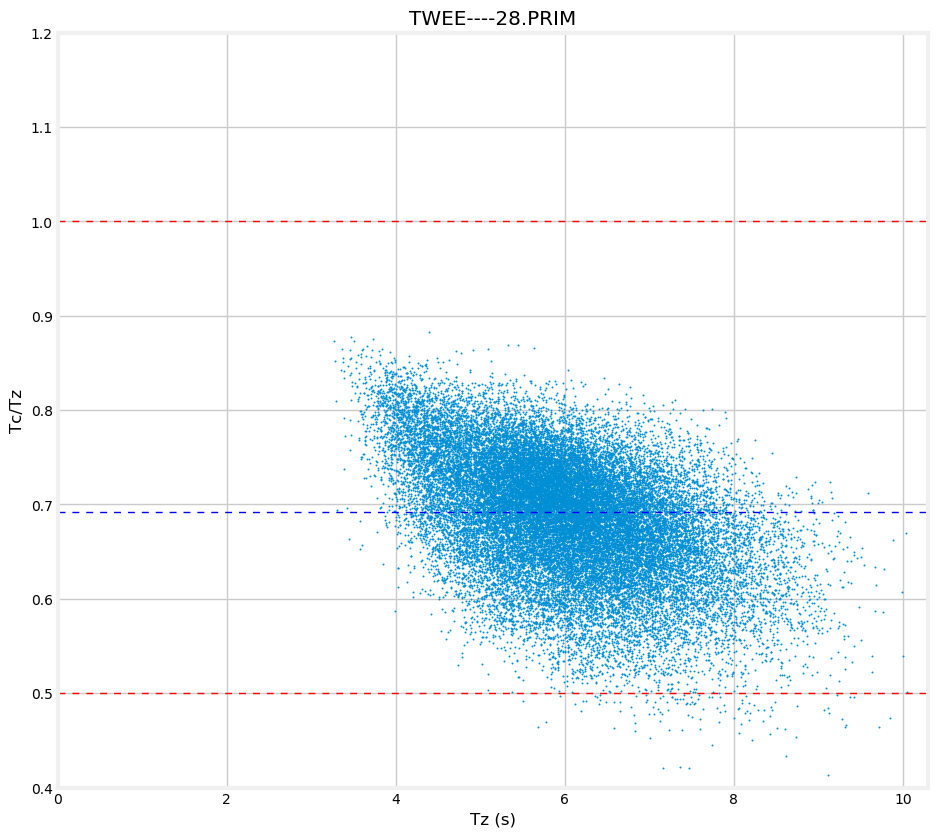

In [13]:
# Do scatter plot of Tc/Tz Ratio

# Generate descriptive statistics of Hm0/Hsig Ratio’s distribution
Ratio = year1.Tc/year1.Tz
median = Ratio.describe()[5]
plt.figure(figsize=(10,10),dpi=100)
year1 = year1.loc[year1.Hsig>0]
plt.scatter(year1.Tz,year1.Tc/year1.Tz,lw=0,marker='o',s=2)
plt.plot([0,max(year1.Tz)],[median,median],lw=1.0,c="b",dashes=[5, 5, 5, 5])
plt.xlabel("Tz (s)")
plt.ylabel("Tc/Tz")
plt.plot([0,max(year1.Tz)],[1.0,1.0],lw=1.0,c="r",dashes=[5, 5, 5, 5])
plt.plot([0,max(year1.Tz)],[0.5,0.5],lw=1.0,c="r",dashes=[5, 5, 5, 5])

plt.xlim(xmin=0,xmax=max(year1.Tz))
plt.ylim(ymin=0.4,ymax=1.2)

plt.title(site)
plt.show()

In [ ]:
merged_df.dropna(inplace=True)

plt.figure(figsize=(10,10),dpi=100)
plt.scatter(merged_df.Hm0,merged_df.hm0,s=0.5,c='g')
plt.xlim(0,8)
plt.ylim(0,8)
plt.xlabel("Hm0 (Prim master)")
plt.ylabel("Hm0 (Dseco master)")
plt.title(site)

from numpy.polynomial import Polynomial

p = Polynomial.fit(merged_df.Hm0, merged_df.hm0, 1)
plt.plot(*p.linspace(),lw=1.0,c="b",dashes=[5, 5, 5, 5])

In [ ]:
plt.figure(figsize=(10,10),dpi=100)
plt.scatter(merged_df.T02,merged_df.t02,s=0.5,c='pink')
plt.xlim(2,12)
plt.ylim(2,12)
plt.xlabel("T02 (Prim master)")
plt.ylabel("T02 (Dseco master)")
plt.title(site)

from numpy.polynomial import Polynomial

p = Polynomial.fit(merged_df.T02, merged_df.t02, 1)
plt.plot(*p.linspace(),lw=1.0,c="b",dashes=[5, 5, 5, 5])

In [ ]:
plt.figure(figsize=(15,10),dpi=100)
aa = merged_df.loc[merged_df.Tp>0]
plt.plot(merged_df.index,merged_df.Hm0-merged_df.hm0,lw=0.5)
plt.ylim(-2,2)

In [ ]:
plt.figure(figsize=(15,10),dpi=100)
aa = merged_df.loc[merged_df.Tp>0]
plt.plot(aa.index,aa.Tp,c='r',lw=0.5)

In [ ]:
plt.figure(figsize=(15,10),dpi=100)
aa = merged_df.loc[merged_df.tp_buoy>0]
plt.plot(aa.index,aa.tp_buoy,c='r',lw=0.5)

In [ ]:
plt.figure(figsize=(10,10),dpi=100)
plt.scatter(aa.hm0,aa.t02,s=0.5,c='r')
plt.scatter(aa.Hm0,aa.T02,s=0.5,c='pink')
plt.xlim(0,10)
plt.ylim(0,15)
plt.xlabel("Hm0")
plt.ylabel("T02")
plt.text(5.1,14,'Red   = Dseco Master')
plt.text(5.1,13,'Pink  = Prim Master')
plt.title(site)

from numpy.polynomial import Polynomial

p = Polynomial.fit(aa.Hm0, aa.T02, 1)
plt.plot(*p.linspace(),lw=1.0,c="b",dashes=[5, 5, 5, 5])


In [ ]:
plt.figure(figsize=(10,10),dpi=100)
plt.scatter(aa.hm0,aa.t02/aa.hm0,s=0.5,c='r')
plt.scatter(aa.Hm0,aa.T02/aa.Hm0,s=0.5,c='pink')
plt.xlim(0,8)
plt.ylim(0,20)
plt.xlabel("Hm0")
plt.ylabel("T02/Hm0")
plt.text(5.1,17,'Red   = Dseco Master')
plt.text(5.1,16,'Pink  = Prim Master')
plt.title(site)

from numpy.polynomial import Polynomial

p = Polynomial.fit(aa.Hm0, aa.t02/aa.hm0, 1)
plt.plot(*p.linspace(),lw=1.0,c="b",dashes=[5, 5, 5, 5])


In [ ]:
plt.figure(figsize=(10,10),dpi=100)


aa = merged_df.loc[merged_df.Hm0>0]
plt.scatter(aa.Hsig,aa.hm0/aa.Hsig,s=0.5,c='yellow')

##year1 = aa.loc['1995-01-01':'1998-08-31']
year1 = aa.loc[:'1998-08-31']
scatter = plt.scatter(year1.Hsig,year1.Hm0/year1.Hsig,s=0.5,c='r')

year2 = aa.loc['1998-09-01':'1999-12-31']
plt.scatter(year2.Hsig,year2.Hm0/year2.Hsig,s=0.5,c='g')

year3 = aa.loc['2000-01-01':'2019-12-31']
plt.scatter(year3.Hsig,year3.Hm0/year3.Hsig,s=0.5,c='pink')

plt.xlabel("Hsig (m)")
plt.ylabel("Hm0/Hsig")
plt.xlim(0,max(aa.Hsig))
plt.ylim(0.8,1.4)
plt.text(3.6,1.31,'Yellow = Dseco Master 1995-01-01 to 2019-12-31')
plt.text(3.6,1.29,'Red    = Prim  Master 1995-01-01 to 1998-08-31')
plt.text(3.6,1.27,'Green  = Prim  Master 1998-09-01 to 1999-12-31')
plt.text(3.6,1.25,'Pink   = Prim  Master 2000-01-01 to 2019-12-31')

plt.plot([0,max(aa.Hsig)],[aa.Hm0.describe()[5]/aa.Hsig.describe()[5],\
                           aa.Hm0.describe()[5]/aa.Hsig.describe()[5]],lw=1.0,c="b",dashes=[5, 5, 5, 5])

plt.plot([0,max(aa.Hsig)],[aa.hm0.describe()[5]/aa.Hsig.describe()[5],\
                           aa.hm0.describe()[5]/aa.Hsig.describe()[5]],lw=1.0,c="yellow",dashes=[5, 5, 5, 5])

plt.plot([0,max(aa.Hsig)],[1.3,1.3],lw=1.0,c="r",dashes=[5, 5, 5, 5])
plt.plot([0,max(aa.Hsig)],[1.0,1.0],lw=1.0,c="r",dashes=[5, 5, 5, 5])